# Essential Import

In [1]:
# common package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# miscellaneous 
from tqdm import tqdm
import scipy.stats
from mpl_toolkits.mplot3d import Axes3D

# helper functions
from utils import *
from preprocess import Preprocess

# models
from gensim.models.doc2vec import Doc2Vec
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import classification_report

# Data Preprocessing

In [2]:
prep = Preprocess('item.csv', 'user.csv', 'user_behavior.csv')
df = prep.init_process()
sc = SessionClassifier()
timeframe = df['time'].to_numpy()
userframe = df['user_id'].to_numpy()
df['new_session'] = sc.stamp_to_signal(userframe, timeframe)
df['label_unbalanced'] = df['age'].apply(lambda x: str(x)).str[0].replace(['9', '8', '7', '6'], '5').apply(lambda x: int(x) - 1)
df['label_balanced'] = df['age'].apply(lambda x: group_age(x))

# Visualization [Optional]

In [3]:
df.head(5)

user_id   item_id type    time  cat_id  shop_id  brand_id  gender  \
940626      279  40410079    b  221239    5296   948294     28570       1   
940686      279  22830135    p  221258   12973   962246    216567       1   
940667      279  26991039    p  221369   11072  2432702    216567       1   
940668      279  26991039    p  221412   11072  2432702    216567       1   
940669      279  26991039    p  221416   11072  2432702    216567       1   

        age  power  new_session  label_unbalanced  label_balanced  
940626   30      1            1                 2               2  
940686   30      1            0                 2               2  
940667   30      1            0                 2               2  
940668   30      1            0                 2               2  
940669   30      1            0                 2               2

# Data Transformation

In [4]:
# initiate the encoder class
pe = PathEncoder()
lst = df.to_numpy()

# corresponding columns to be encoded as path
path_col_index = [1,4,5,6]
title_col = [df.columns[i] for i in path_col_index]

# encode viewing history as path
lst_result = []
lst_dics = []
lst_actions_sum = []
for index in path_col_index:
    pe.set_cat(index)
    result, dic, actions_sum = pe.get_path(lst, mode = 'full_modified')
    lst_result.append(result)
    lst_dics.append(dic)
    lst_actions_sum.append(actions_sum)

# transform path as the input for tagged documents and mapping dictionary
sentences_docs_lst = []
map_dic_lst = []
for dic in lst_dics:
    sentences_doc, map_dic = get_sentences_doc(dic)
    sentences_docs_lst.append(sentences_doc)
    map_dic_lst.append(map_dic)

# build tagged documents from transformed path
documents_lst = []
for sentences_docs in sentences_docs_lst:
    documents = get_documents(sentences_docs)
    documents_lst.append(documents)
    
# build the inverse of map_dic
inv_map_lst = [{v: k for k, v in map_dic.items()} for map_dic in map_dic_lst]

# Visualzation [Optional]

In [5]:
documents_lst[0][0]

TaggedDocument(words=['b40410079', 'p22830135', 'p26991039', 'p26991039x', 'p14027124', 'f28270315', 'p35691221', 'p40291124', 'p29238588', 'p28270315', 'p6440229', 'f35829863', 'p11949954', 'p39046777', 'p18821181', 'p33094004', 'p16577496', 'p24903693', 'p12579266', 'p19563589', 'b12579266', 'p26991039', 'p32551586', 'p12619624', 'p35691221', 'p9016213', 'p28447881', 'p6209524', 'p6233634', 'p31957385', 'p20675979', 'p6233634', 'p18821181', 'f11429680', 'p8563896', 'p35691221', 'p32475263', 'p25645133', 'p29706693', 'p20210657', 'p31386755', 'p31386755x', 'p3321291', 'p7488085', 'b3321291', 'f16663644', 'p40626877', 'p33828756', 'p3321291', 'p28019828', 'p20210657', 'p20210657x', 'b20210657', 'p23326995', 'p11349276', 'p10715952', 'f40559724', 'p28529301', 'p40559724', 'p40559724x', 'p40410079', 'p28756126', 'f10754411', 'p852621', 'p10754411', 'p8713690', 'p10754411', 'p10164893', 'p15952244', 'p410467', 'p10754411', 'p4827584', 'p6735395', 'p23349698', 'p10754411', 'p26211487', 'p1

# Data Vectorization (Modeling - Slow)

In [6]:
# # build Doc2Vec Models for each kind of path
# d2v_models_lst = []
# for documents in documents_lst:
#     model = Doc2Vec(documents)
#     model.train(documents, total_examples=model.corpus_count, epochs=30)
#     d2v_models_lst.append(model)
    
# # save the models
# for i in range(len(d2v_models_lst)):
#     d2v_models_lst[i].save("d2v{}.model".format(path_col_index[i]))

# Data Clustering (Modeling - Fast)

In [7]:
# load the models
d2v_models_lst = []
for i in range(len(path_col_index)):
    model= Doc2Vec.load("d2v{}.model".format(path_col_index[i]))
    d2v_models_lst.append(model)

# build KMeans clusters for each user vector within each Doc2Vec models
K = 8
group_lst = []
for model in d2v_models_lst:
    group = KMeans(n_clusters=K, max_iter=100).fit_predict(model.docvecs.vectors_docs)
    group_lst.append(group)

# Visualization [Optional]

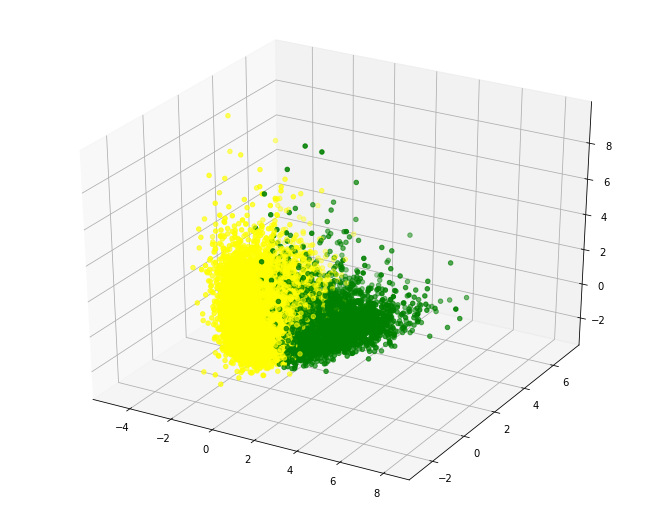

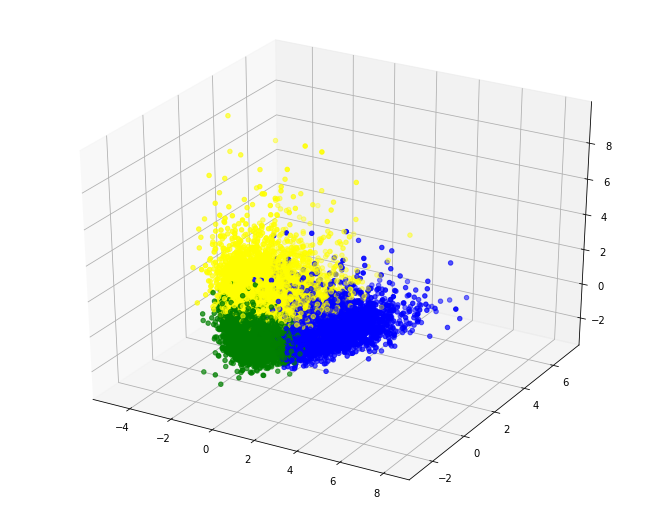

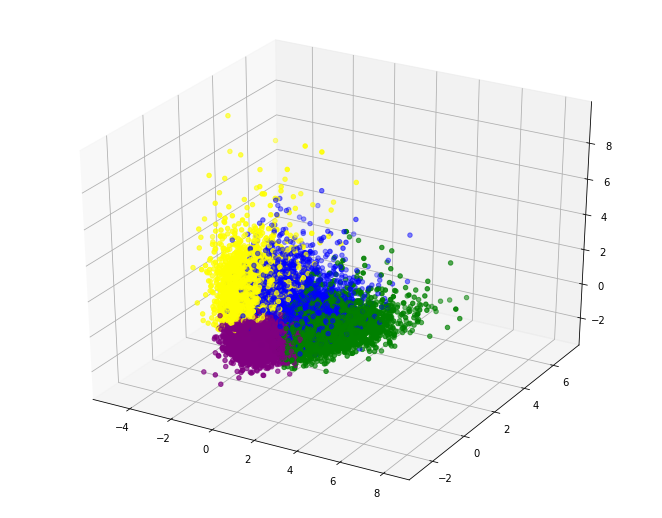

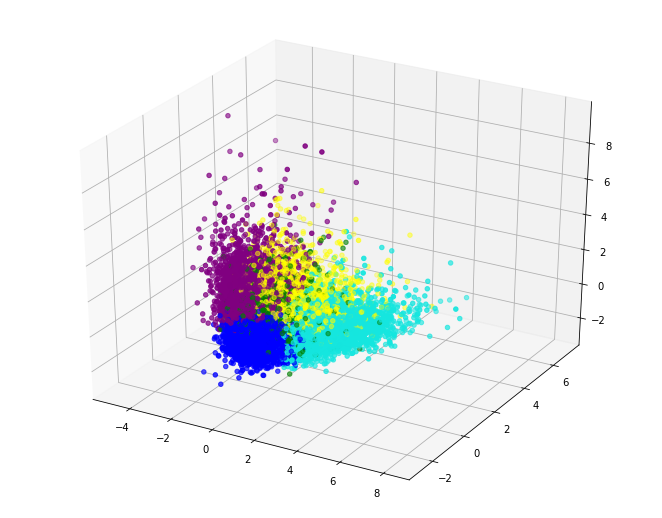

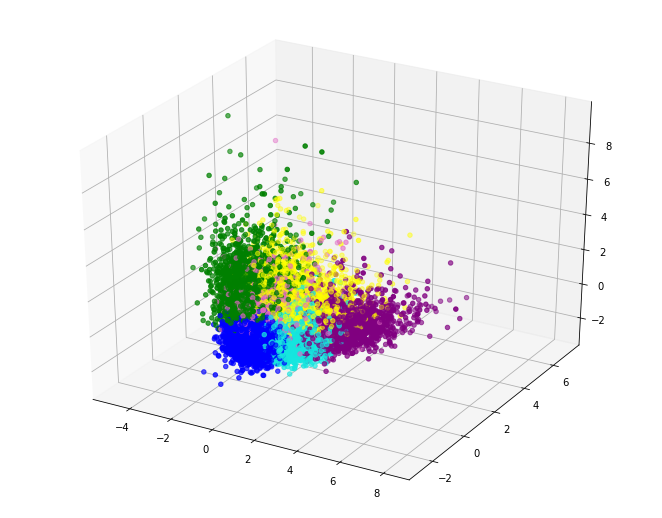

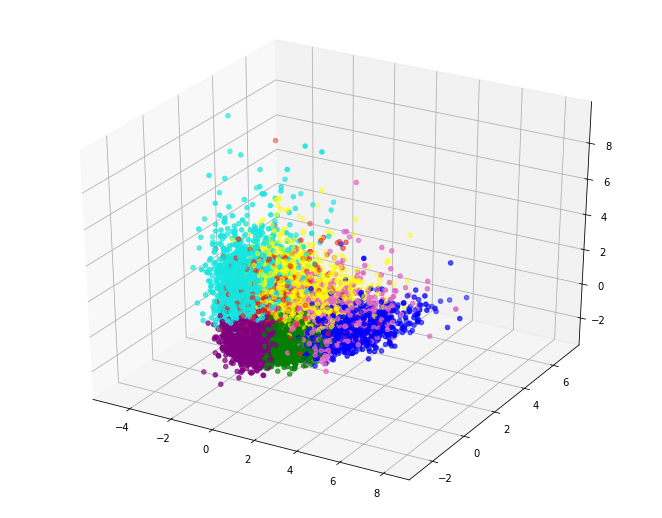

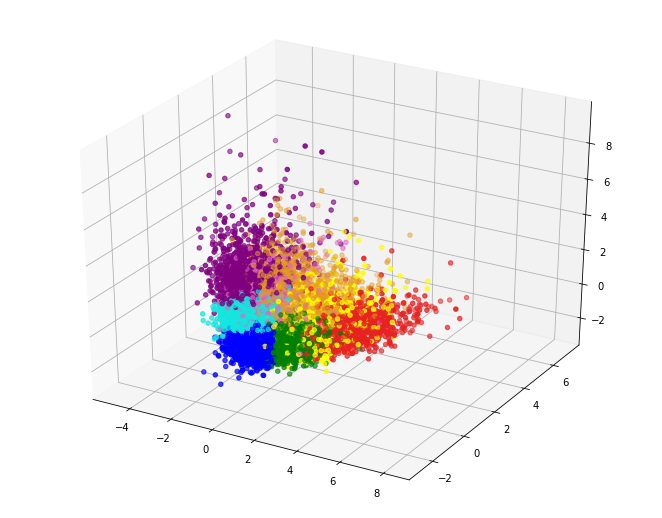

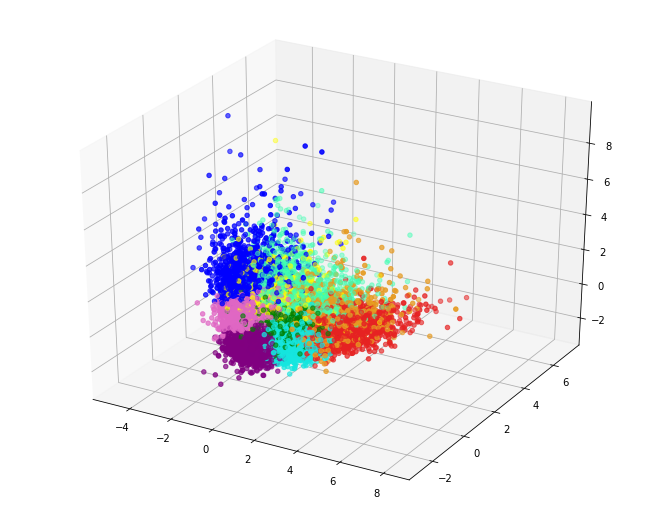

In [8]:
for i in range(2, 10):
    kmeans_model = KMeans(n_clusters=i, init='k-means++', max_iter=100) 
    X = kmeans_model.fit(d2v_models_lst[0].docvecs.vectors_docs)
    labels=kmeans_model.labels_.tolist()
    l = kmeans_model.fit_predict(d2v_models_lst[0].docvecs.vectors_docs)
    pca = PCA(n_components=3).fit(d2v_models_lst[0].docvecs.vectors_docs)
    datapoint = pca.transform(d2v_models_lst[0].docvecs.vectors_docs)
    fig = plt.figure(figsize=(9, 7))
    ax = Axes3D(fig)
    label1 = ['#FFFF00', '#008000', '#0000FF', '#800080', '#15e6df', '#e067c4', '#e62222', '#e69b22', '#40ffb3', '#44d2f2']
    color = [label1[i] for i in labels]
    ax.scatter(datapoint[:, 0], datapoint[:, 1], datapoint[:, 2], c=color)
    centroids = kmeans_model.cluster_centers_
    centroidpoint = pca.transform(centroids)
    ax.scatter(centroidpoint[:, 0], centroidpoint[:, 1], centroidpoint[:, 2], marker='^', c='#000000')
    plt.show()
    
# plot_sil_sse(sil, sse)

# Statistical Verification for Frequent Paths [Optional]

In [9]:
print("Build grouped_user list of dictionary", end = " ... ")

# build grouped user 
partition_lst = []
for i in range(len(group_lst)):
    partition = partition_user_group(map_dic_lst[i], group_lst[i], lst_dics[i])
    partition_lst.append(partition)

print("finished")    
print("Build aggregated sentence for each group", end = " ... ")

# build aggregated sentence for each group
ls_lst = []
for partition in partition_lst:
    lst_sentence = ld_to_ls(partition)
    ls_lst.append(lst_sentence)
    
print("finished")    
print("Build n-gram for each type of path with specific user group", end = " ... ")
    
# build n-gram for each type of path with specific user group
# eg. ngram_lst[0][0] means the path n-gram for user_group 0 for their item_id data
# eg. ngram_lst[1][2] means the path n-gram for user_group 2 for their cat_id data
n_grams_lst = []
for ls in ls_lst:
    temp = [build_ngram_from_string(ls[i], length = 10) for i in range(K)]
    n_grams_lst.append(temp)

print("finished")    
print("Build sample stats for each group's frequent path/behavior", end = " ... ")
    
# build sample stats for each group's frequent path/behavior
COMPARISON_GROUP = 2
sample_stat_lst = []
for path_type in range(len(path_col_index)):
    sample_stat_lst.append([])
    for i, _type in enumerate(['page', 'behavior']):
        sample_stat_lst[path_type].append([])
        for group_label in range(COMPARISON_GROUP):
            sample_stat_lst[path_type][i].append\
            (calculate_stat(n_grams_lst[path_type][group_label], normalization = True, mode = _type))
            
print("finished")

Build grouped_user list of dictionary ... finished
Build aggregated sentence for each group ... finished
Build n-gram for each type of path with specific user group ... finished
Build sample stats for each group's frequent path/behavior ... finished


# Visualization [Optional]

In [10]:
DISPLAY_NUM = 5
for path_type in range(len(path_col_index)):
    print("Path Type = {}".format(path_type), end = "\n")
    for _type in range(len(['page', 'behavior'])):
        print(['Page', 'Behavior'][_type], end = "\n")
        for group_label in range(COMPARISON_GROUP):
            print("Group = {}".format(group_label))
            for i in range(DISPLAY_NUM):
                if (i < len(sample_stat_lst[path_type][group_label][_type])):
                    print(sample_stat_lst[path_type][group_label][_type][i])

Path Type = 0
Page
Group = 0
[('24884366', '27354353', '10335776', '13482763'), 0.15819209039548024]
[('31775392', '27507619', '31775392', '27507619'), 0.11864406779661017]
[('7180901', '10366372', '7180901', '10366372'), 0.11864406779661017]
[('10366372', '7180901', '10366372', '7180901'), 0.11299435028248588]
[('27507619', '31775392', '27507619', '31775392'), 0.096045197740113]
Group = 1
[('p', 'p', 'p', 'p'), 1.0]
Behavior
Group = 0
[('37940136', '14808276', '37940136', '14808276'), 0.15053763440860216]
[('14808276', '37940136', '14808276', '37940136'), 0.15053763440860216]
[('5264777', '28470380', '5264777', '28470380'), 0.11827956989247312]
[('28470380', '5264777', '28470380', '5264777'), 0.10752688172043011]
[('2437626', '9264728', '2437626', '9264728'), 0.08602150537634409]
Group = 1
[('p', 'p', 'p', 'p'), 1.0]
Path Type = 1
Page
Group = 0
[('7441', '7441', '7441', '7441'), 0.39925373134328357]
[('8913', '8913', '8913', '8913'), 0.1044776119402985]
[('12475', '12475', '12475', '

# Generate User Info Distribution for Each Group (Slow) [Optional]

In [11]:
dftemp = pd.read_csv('user.csv')
dftemp.columns = ['user_id', 'gender', 'age', 'power']

age_groups_lst = []
gender_groups_lst = []
for i in range(len(inv_map_lst)): 
    age_groups, gender_groups = generate_user_info_distribution(df, dftemp, inv_map_lst[i], group_lst[i], K = K)
    age_groups_lst.append(age_groups)
    gender_groups_lst.append(gender_groups)
    
del dftemp

# Visualization [Optional]

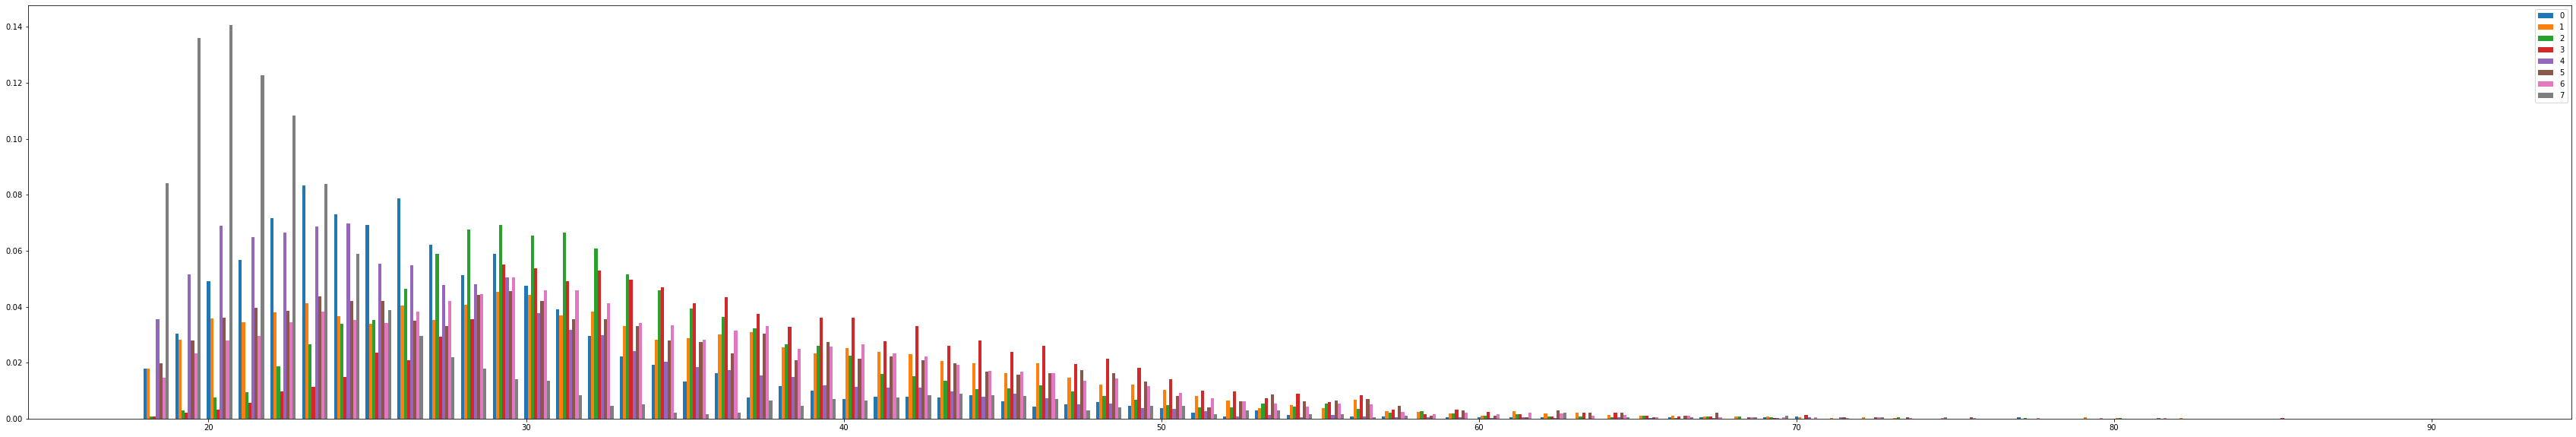

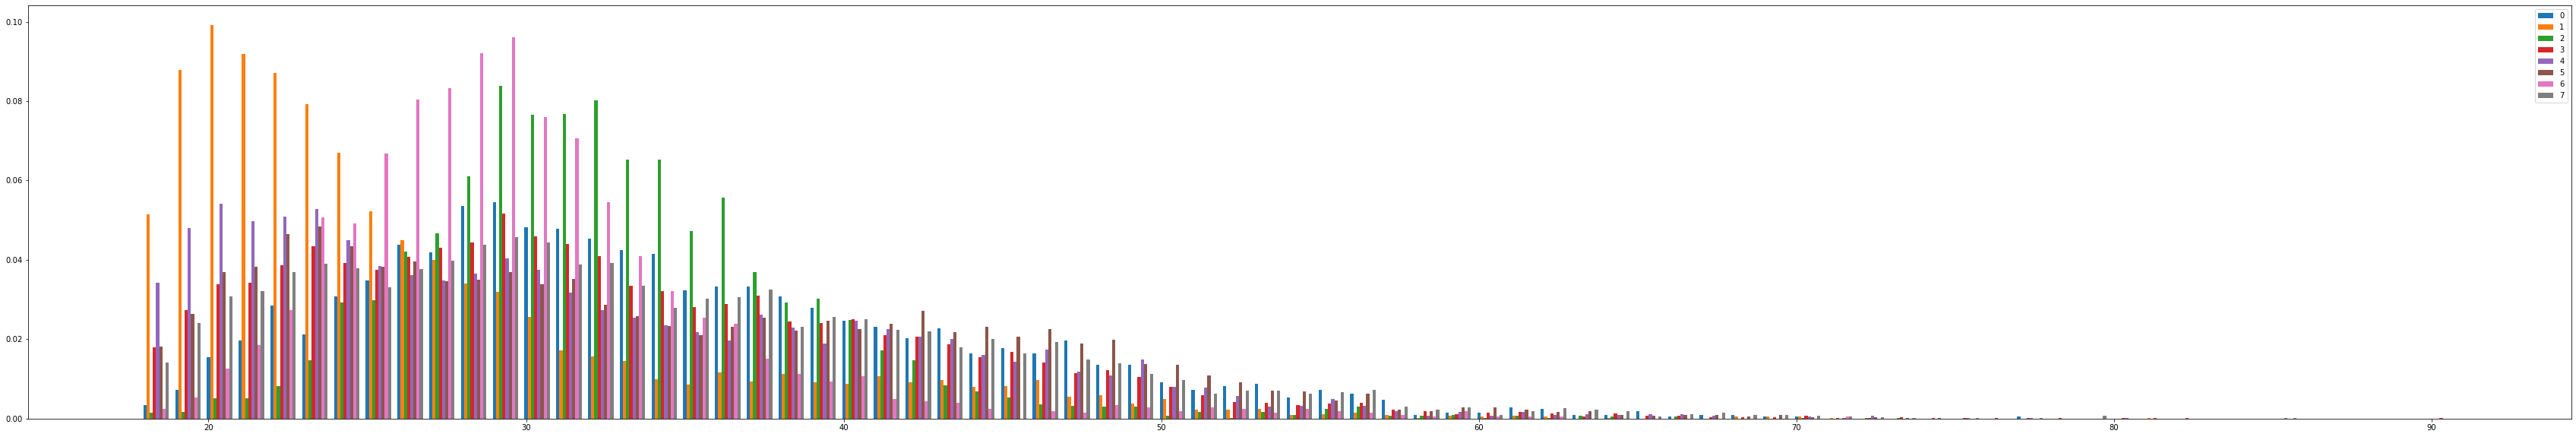

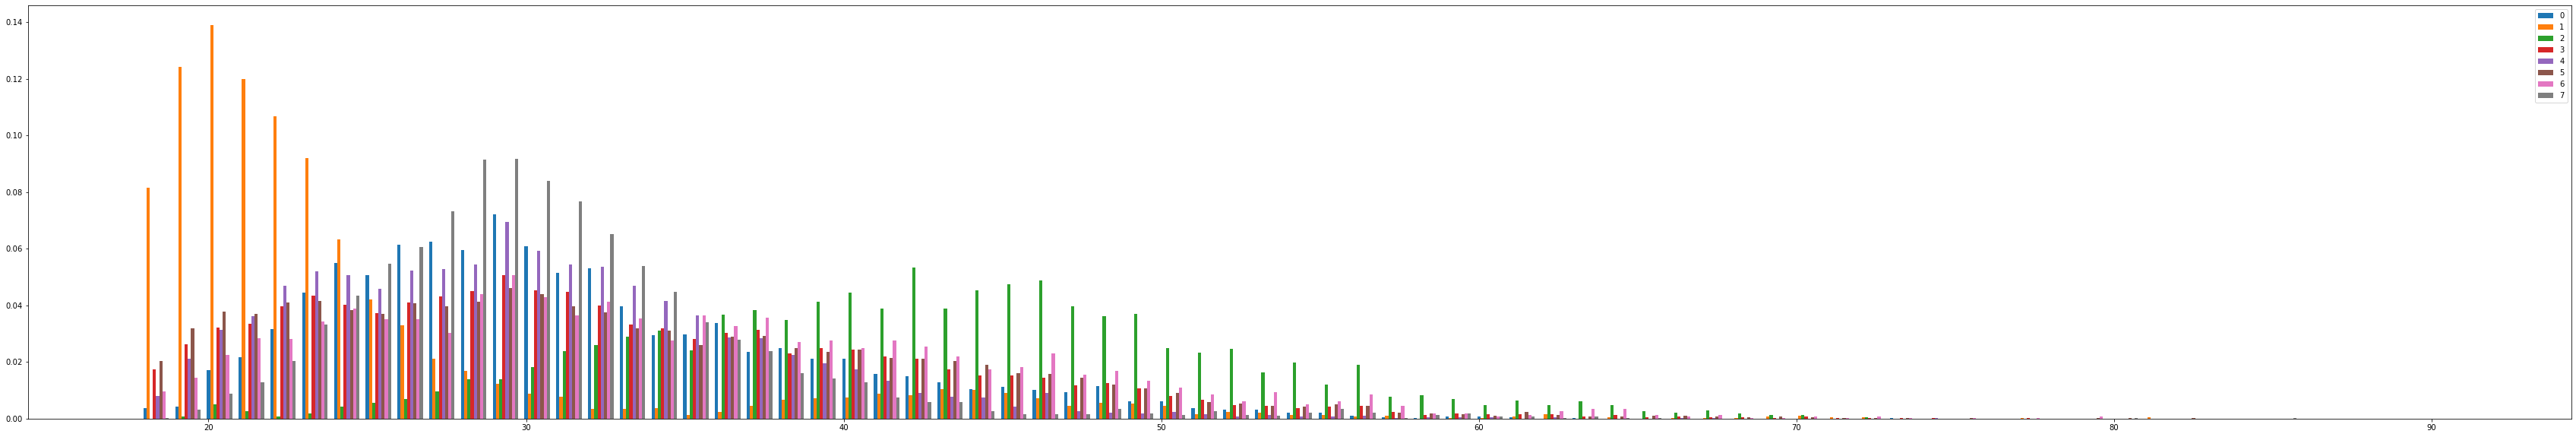

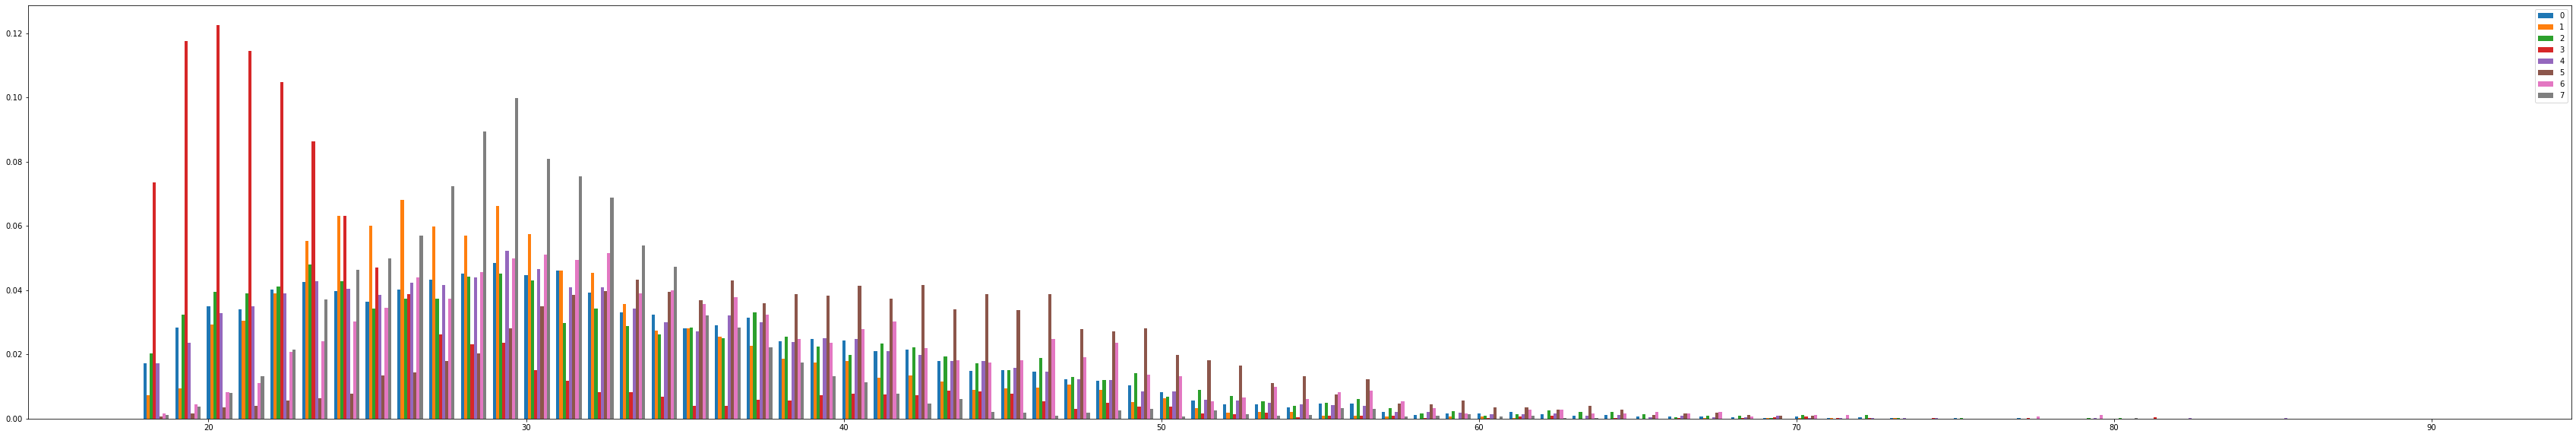

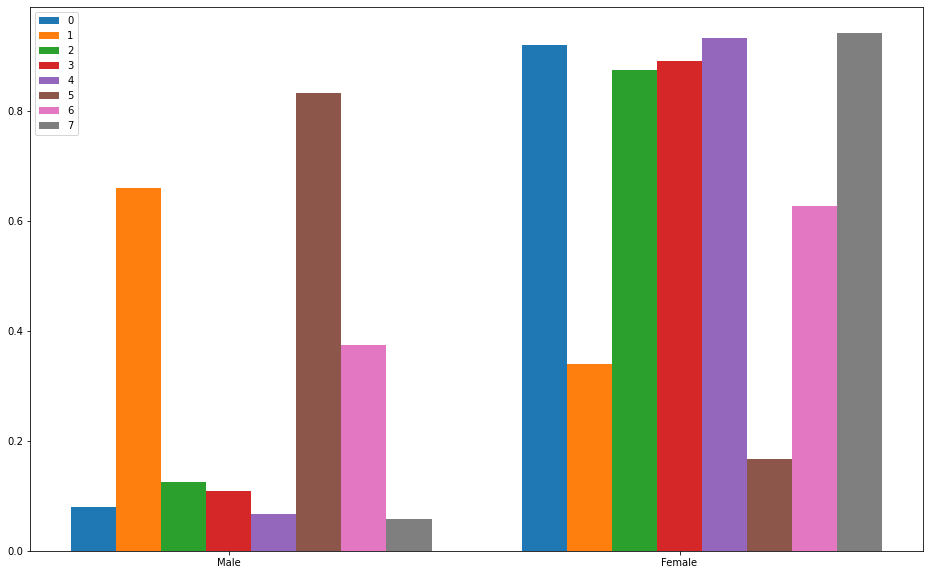

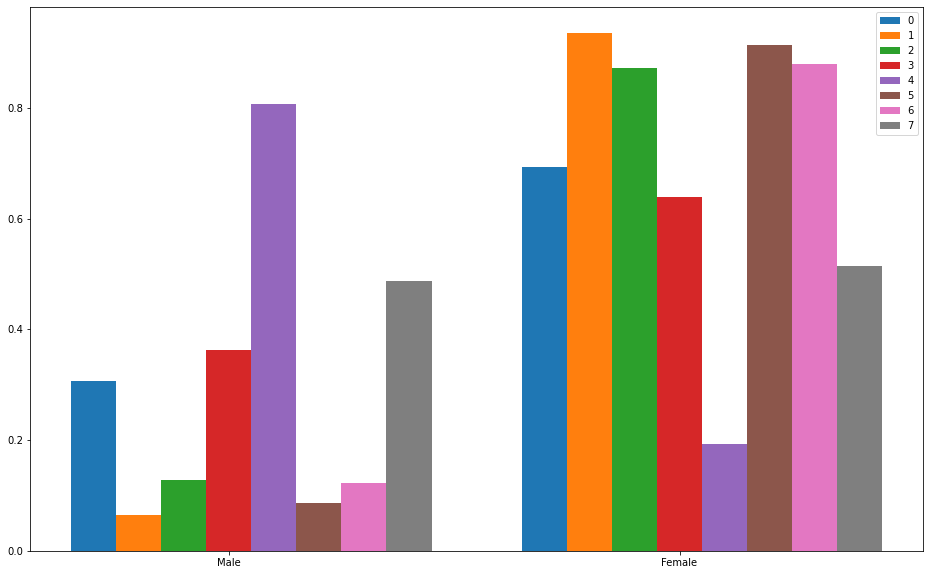

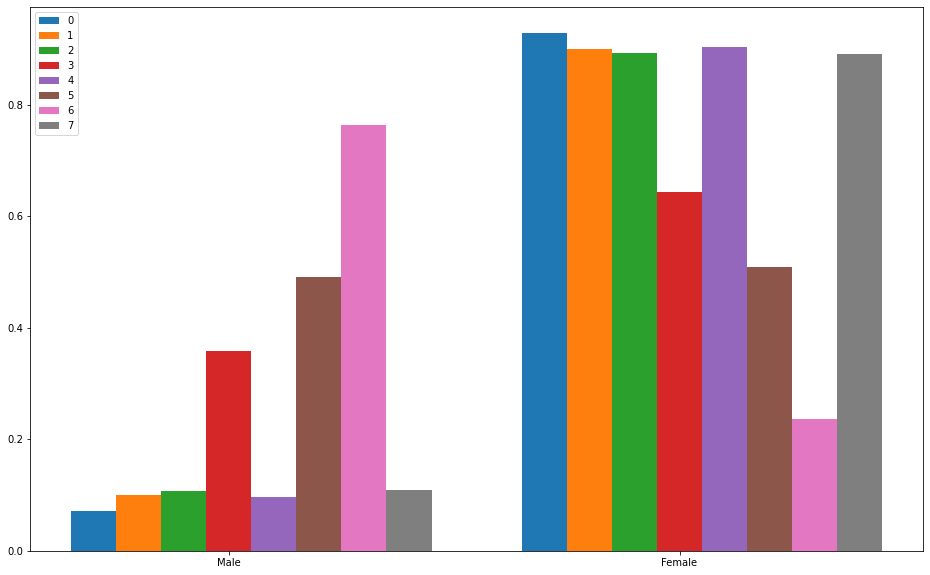

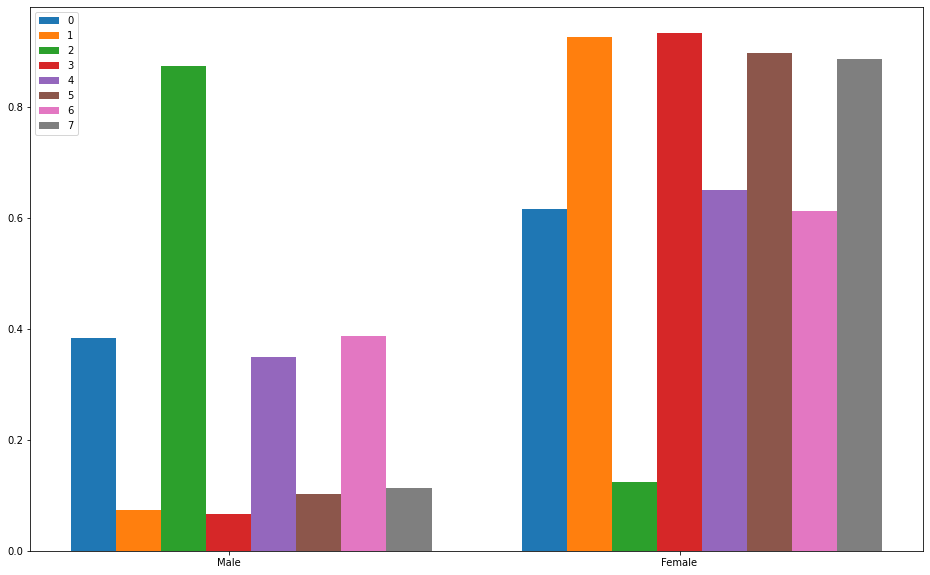

In [12]:
def plot_age_distribution(age_groups_lst):
    for age_groups in age_groups_lst:
        indices = np.array(df['age'].unique().tolist())
        width = 0.1
        fig = plt.gcf()
        fig.set_size_inches(60, 10)
        for i in range(K - 1):
            plt.bar(indices + width*i, np.array(list(age_groups[i].values()))/sum(list(age_groups[i].values())), width, label='{}'.format(i))
        plt.bar(indices + width*(i+1), np.array(list(age_groups[K - 1].values()))/sum(list(age_groups[K - 1].values())), width, label='{}'.format(K - 1))
        plt.legend(loc='best')
        plt.show()

def plot_gender_distribution(gender_groups_lst):
    for gender_groups in gender_groups_lst:
        indices = np.array(df['gender'].unique().tolist())
        width = 0.1
        fig = plt.gcf()
        fig.set_size_inches(16, 10)
        for i in range(K - 1):
            plt.bar(indices + width*i, np.array(list(gender_groups[i].values()))/sum(list(gender_groups[i].values())), width, label='{}'.format(i))
        plt.bar(indices + width*(i+1), np.array(list(gender_groups[K - 1].values()))/sum(list(gender_groups[K - 1].values())), width, label='{}'.format(K - 1))
        plt.xticks(indices + width*3, ('Female', 'Male'))
        plt.legend(loc='best')
        plt.show()

plot_age_distribution(age_groups_lst)
plot_gender_distribution(gender_groups_lst)

# Attribution Analysis

In [13]:
path_data_lst = []
for i in range(len(group_lst)):
    for j in tqdm(range(0, K+1)):
        path_data_lst.append([])
        path_data = aggregate_group_path_data(lst_dics[i], map_dic_lst[i], group_lst[i], group = j-1)
        path_data_lst[i].append(path_data)

# dic cannot be built upon brand_id because it contains to many unknow brands as -1
reason_dic_lst = []
for i in range(len(group_lst) - 1):
    for j in tqdm(range(0, K+1)):
        reason_dic_lst.append([])
        reason_dic = analyze_sequence_by_prior_sequence\
                  (path_data_lst[i][j], mode = 'last', discard_same_page = False, count_blank = True)
        reason_dic_lst[i].append(reason_dic)

100%|██████████| 9/9 [00:27<00:00,  3.01s/it]


# Attribution Analysis Report with Partitioned Group [Optional]

In [14]:
# Query single reasoning coefficient
# for key in reason_dic_lst[0]:
#     validate_reason_last(key, path_data_lst[0], reason_dic_lst[0], amount = 10)

for k in range(int(len(reason_dic_lst)/len(reason_dic_lst[0]))):
    validation_report(path_data_lst[k], reason_dic_lst[k], title = "Path Constructed by: {}".format(title_col[k]), K = K)

---------------------------------------------------------------------
Path Constructed by: item_id
Group -1 | Macro Accuracy: 0.7534601252081541 | Weighted Accuracy: 0.3347449684876893
Group 0 | Macro Accuracy: 0.8226142608967039 | Weighted Accuracy: 0.4966169922730122
Group 1 | Macro Accuracy: 0.8476923766791497 | Weighted Accuracy: 0.5210717839918043
Group 2 | Macro Accuracy: 0.825083102087142 | Weighted Accuracy: 0.4864820252728828
Group 3 | Macro Accuracy: 0.8036253733470817 | Weighted Accuracy: 0.46764433474793965
Group 4 | Macro Accuracy: 0.8323921172677644 | Weighted Accuracy: 0.49471483715401954
Group 5 | Macro Accuracy: 0.8277411311628649 | Weighted Accuracy: 0.5153664512452513
Group 6 | Macro Accuracy: 0.8699514055948352 | Weighted Accuracy: 0.5067350569089156
Group 7 | Macro Accuracy: 0.8047645664440346 | Weighted Accuracy: 0.46781037359962624

Without Clustering:
Macro Accuracy: 0.7534601252081541 | Weighted Accuracy: 0.3347449684876893

With Clstering:
Macro Accuracy: 0.82

# Clustering Verification by Embedding

In [15]:
N = 8

# generate embeddings for each kind of path
embed_lst = []
for i in range(len(group_lst)):
    group = group_lst[i]
    inv_map = inv_map_lst[i]
    embed_lst.append(generate_embed(group, inv_map, df))
embeds = np.transpose(np.array(embed_lst))

# create a temporary dataframe for embeddings
embed_col = ['embed_{}'.format(name) for name in title_col]
df_embed = pd.DataFrame(data = embeds, index = df.index, columns = embed_col)
to_reduce = []

# transform embeddings dataframe to one-hot encoding
for col_name in embed_col:
    embed_dum = pd.get_dummies(df_embed[col_name])
    for i in range(K): to_reduce.append(embed_dum[i].tolist())

# reduce embedding data to N dimensions
to_reduce = np.transpose(np.array(to_reduce))
pca = PCA(n_components = N)
reduced_embeds = pca.fit_transform(to_reduce)

# add reduced embedding data to dataframe
embed_col = ["embed_dim_{}".format(i) for i in range(1, N + 1)]
df_reduced_embeds = pd.DataFrame(data = reduced_embeds, index = df.index, columns = embed_col)
df = df.join(df_reduced_embeds)

# add behavior data as one-hot encoding to dataframe
df_type = pd.get_dummies(df['type'])
df_type_col = ['beh_b', 'beh_c', 'beh_f', 'beh_p']
df_type.columns = df_type_col
df = df.join(df_type)

# Visualization [Optional]

In [16]:
df.head(5)

user_id   item_id type    time  cat_id  shop_id  brand_id  gender  \
940626      279  40410079    b  221239    5296   948294     28570       1   
940686      279  22830135    p  221258   12973   962246    216567       1   
940667      279  26991039    p  221369   11072  2432702    216567       1   
940668      279  26991039    p  221412   11072  2432702    216567       1   
940669      279  26991039    p  221416   11072  2432702    216567       1   

        age  power  ...  embed_dim_3  embed_dim_4  embed_dim_5  embed_dim_6  \
940626   30      1  ...     0.948022    -0.140931    -0.429757    -0.013779   
940686   30      1  ...     0.948022    -0.140931    -0.429757    -0.013779   
940667   30      1  ...     0.948022    -0.140931    -0.429757    -0.013779   
940668   30      1  ...     0.948022    -0.140931    -0.429757    -0.013779   
940669   30      1  ...     0.948022    -0.140931    -0.429757    -0.013779   

        embed_dim_7  embed_dim_8  beh_b  beh_c  beh_f  beh_p  
940626     0.110143     0.851477      1      0      0      0  
940686     0.110143     0.851477      0      0      0      1  
940667     0.110143     0.851477      0      0      0      1  
940668     0.110143     0.851477      0      0      0      1  
940669     0.110143     0.851477      0      0      0      1  

[5 rows x 25 columns]

# Multiclass Classification Model over Unbalanced Age Group(XGBoost)

Age Classification without Path Clustering


C:\Users\Colin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     34983
           1       0.43      0.97      0.60    314426
           2       0.37      0.04      0.08    233737
           3       0.27      0.00      0.00    111001
           4       0.00      0.00      0.00     38775

    accuracy                           0.43    732922
   macro avg       0.21      0.20      0.14    732922
weighted avg       0.35      0.43      0.28    732922

Confusion matrix, without normalization
[[     0  34195    787      1      0]
 [     0 305818   8587     21      0]
 [     0 223839   9877     21      0]
 [     0 105718   5265     18      0]
 [     0  36747   2022      6      0]]
Normalized confusion matrix
[[0.00000000e+00 9.77474773e-01 2.24966412e-02 2.85853129e-05
  0.00000000e+00]
 [0.00000000e+00 9.72623129e-01 2.73100825e-02 6.67883699e-05
  0.00000000e+00]
 [0.00000000e+00 9.57653260e-01 4.22568956e-02 8.98445689e-05
  0.00000000e+00]
 [0.00000000

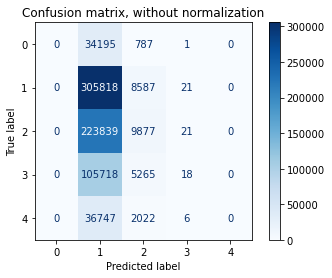

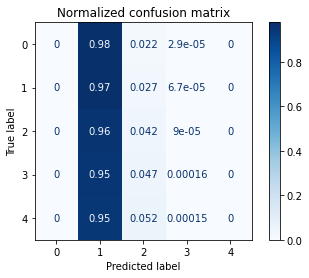

Age Classification with Path Clustering
              precision    recall  f1-score   support

           0       0.76      0.04      0.07     34983
           1       0.57      0.79      0.66    314426
           2       0.53      0.51      0.52    233737
           3       0.52      0.27      0.36    111001
           4       0.59      0.08      0.13     38775

    accuracy                           0.55    732922
   macro avg       0.59      0.34      0.35    732922
weighted avg       0.56      0.55      0.51    732922

Confusion matrix, without normalization
[[  1254  31831   1828     70      0]
 [   228 249646  60285   3852    415]
 [    66 100449 119440  13124    658]
 [    80  45089  34474  30360    998]
 [    15  14174  11177  10488   2921]]
Normalized confusion matrix
[[3.58459823e-02 9.09899094e-01 5.22539519e-02 2.00097190e-03
  0.00000000e+00]
 [7.25130873e-04 7.93973781e-01 1.91730328e-01 1.22508953e-02
  1.31986541e-03]
 [2.82368645e-04 4.29752243e-01 5.11001681e-01 5.614

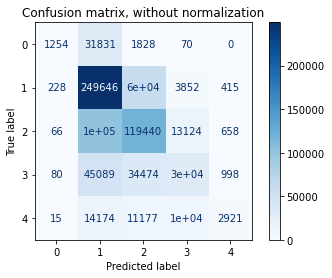

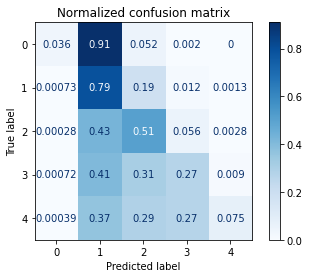

('new_session', 0.002392162)
('beh_b', 0.0065037357)
('beh_c', 0.006366512)
('beh_f', 0.009621514)
('beh_p', 0.004681309)
('time', 0.012955252)
('embed_dim_1', 0.07437169)
('embed_dim_2', 0.07596885)
('embed_dim_3', 0.28262696)
('embed_dim_4', 0.24713342)
('embed_dim_5', 0.0795425)
('embed_dim_6', 0.071293145)
('embed_dim_7', 0.04892026)
('embed_dim_8', 0.077622734)
Path Clustering Feature Relative Importance：0.9574795514345169


In [17]:
# Classification without Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p', 'time']
X = df[X_col]
y = df['label_unbalanced']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Age Classification without Path Clustering")
print(classification_report(y_test, result))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                               # display_labels=class_names1,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()

# Classification with Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p', 'time'] + embed_col
X = df[X_col]
y = df['label_unbalanced']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Age Classification with Path Clustering")
print(classification_report(y_test, result))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                               # display_labels=class_names1,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()

# Path Clustering Feature Contribution to Model Weights
temp = list(zip(X_col, clf.feature_importances_))
for i in range(len(temp)):
    print(temp[i]) 
_sum = 0
for i in range(6, len(temp)):
    _sum += temp[i][1] 
print("Path Clustering Feature Relative Importance：{}".format(_sum))

# Multiclass Classification Model over Balanced Age Group(XGBoost)

Age Classification without Path Clustering
              precision    recall  f1-score   support

           0       0.24      0.36      0.29    152950
           1       0.24      0.00      0.00    124646
           2       0.22      0.02      0.04    136301
           3       0.23      0.11      0.15    153278
           4       0.24      0.61      0.35    165747

    accuracy                           0.24    732922
   macro avg       0.24      0.22      0.16    732922
weighted avg       0.24      0.24      0.18    732922

Confusion matrix, without normalization
[[ 55274    116   2805  13623  81132]
 [ 40663    128   2391  11958  69506]
 [ 42599     77   3134  13327  77164]
 [ 45363    112   2887  16263  88653]
 [ 47060     99   2769  15189 100630]]
Normalized confusion matrix
[[3.61386074e-01 7.58417784e-04 1.83393266e-02 8.90683230e-02
  5.30447859e-01]
 [3.26227877e-01 1.02690820e-03 1.91823243e-02 9.59356899e-02
  5.57627200e-01]
 [3.12536225e-01 5.64926156e-04 2.29932282e-02 9.

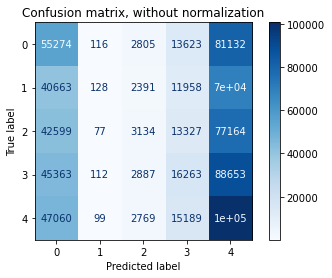

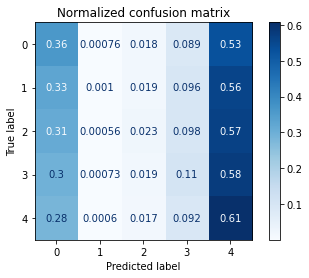

Age Classification with Path Clustering
              precision    recall  f1-score   support

           0       0.56      0.64      0.60    152950
           1       0.45      0.23      0.30    124646
           2       0.43      0.29      0.35    136301
           3       0.44      0.36      0.39    153278
           4       0.42      0.70      0.52    165747

    accuracy                           0.46    732922
   macro avg       0.46      0.44      0.43    732922
weighted avg       0.46      0.46      0.44    732922

Confusion matrix, without normalization
[[ 97780   9941   7867   7648  29714]
 [ 30245  28352  18970  15264  31815]
 [ 15630  11645  40070  26980  41976]
 [ 11993   7686  20303  54464  58832]
 [ 18789   5104   6688  19870 115296]]
Normalized confusion matrix
[[0.63929389 0.0649951  0.05143511 0.05000327 0.19427264]
 [0.24264718 0.22746017 0.152191   0.1224588  0.25524285]
 [0.11467267 0.08543591 0.2939817  0.19794426 0.30796546]
 [0.07824345 0.05014418 0.13245867 0.3

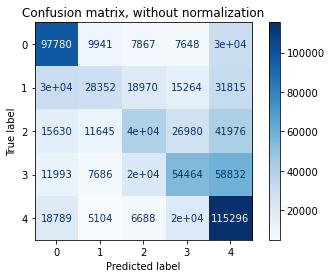

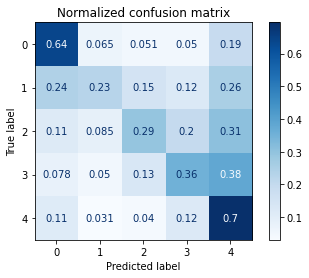

('new_session', 0.0023009244)
('beh_b', 0.0037570342)
('beh_c', 0.005786406)
('beh_f', 0.007597619)
('beh_p', 0.0039792764)
('time', 0.011652075)
('embed_dim_1', 0.05700931)
('embed_dim_2', 0.09245034)
('embed_dim_3', 0.34842554)
('embed_dim_4', 0.21034999)
('embed_dim_5', 0.07934962)
('embed_dim_6', 0.0674926)
('embed_dim_7', 0.04081827)
('embed_dim_8', 0.06903106)
Path Clustering Feature Relative Importance：0.9649267308413982


In [18]:
# Classification without Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p', 'time']
X = df[X_col]
y = df['label_balanced']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Age Classification without Path Clustering")
print(classification_report(y_test, result))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                               # display_labels=class_names1,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()

# Classification with Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p', 'time'] + embed_col
X = df[X_col]
y = df['label_balanced']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Age Classification with Path Clustering")
print(classification_report(y_test, result))
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                               # display_labels=class_names1,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
plt.show()

# Path Clustering Feature Contribution to Model Weights
temp = list(zip(X_col, clf.feature_importances_))
for i in range(len(temp)):
    print(temp[i]) 
_sum = 0
for i in range(6, len(temp)):
    _sum += temp[i][1] 
print("Path Clustering Feature Relative Importance：{}".format(_sum))

# Regression Model over Age (XGBoost)

In [19]:
# Regression without Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p', 'time']
X = df[X_col]
y = df['age']
X_train, X_test, y_train, y_test_without_embeddings = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBRegressor(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result_without_embeddings = clf.predict(X_test)

# Regression with Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p', 'time'] + embed_col
X = df[X_col]
y = df['age']
X_train, X_test, y_train, y_test_with_embeddings = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBRegressor(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result_with_embeddings = clf.predict(X_test)

print("Explained Varience Score without Path Clustering Features: {}".format\
      (explained_variance_score(y_test_without_embeddings, result_without_embeddings)))
print("Explained Varience Score with Path Clustering Features: {}".format\
      (explained_variance_score(y_test_with_embeddings, result_with_embeddings)))
print()

print("Mean Squared Error without Path Clustering Features: {}".format\
      (mean_squared_error(y_test_without_embeddings, result_without_embeddings)))
print("Mean Squared Error with Path Clustering Features: {}".format\
      (mean_squared_error(y_test_with_embeddings, result_with_embeddings)))
print()

print("Mean Absolute Error without Path Clustering Features: {}".format\
      (mean_absolute_error(y_test_without_embeddings, result_without_embeddings)))
print("Mean Absolute Error with Path Clustering Features: {}".format\
      (mean_absolute_error(y_test_with_embeddings, result_with_embeddings)))
print()

Explained Varience Score without Path Clustering Features: 0.006841957627061412
Explained Varience Score with Path Clustering Features: 0.3130052552489362

Mean Squared Error without Path Clustering Features: 91.49775937351009
Mean Squared Error with Path Clustering Features: 63.291537825644966

Mean Absolute Error without Path Clustering Features: 7.595422869264912
Mean Absolute Error with Path Clustering Features: 5.90505474569291



# Classification Model over Gender (XGBoost)

In [20]:
# Classification without Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p']
X = df[X_col]
y = df['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Gender Classification without Path Clustering")
print(classification_report(y_test, result))

# Classification with Path Clustering
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p'] + embed_col
X = df[X_col]
y = df['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Gender Classification with Path Clustering")
print(classification_report(y_test, result))

Gender Classification without Path Clustering


C:\Users\Colin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00    189281
           1       0.74      1.00      0.85    543641

    accuracy                           0.74    732922
   macro avg       0.37      0.50      0.43    732922
weighted avg       0.55      0.74      0.63    732922

Gender Classification with Path Clustering
              precision    recall  f1-score   support

           0       0.80      0.60      0.68    189281
           1       0.87      0.95      0.91    543641

    accuracy                           0.86    732922
   macro avg       0.83      0.77      0.80    732922
weighted avg       0.85      0.86      0.85    732922



# Multiclass Classification Model over Power Group (XGBoost)

In [21]:
X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p']
X = df[X_col]
y = df['power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Power Classification without Path Clustering")
print(classification_report(y_test, result))

X_col = ['new_session', 'beh_b', 'beh_c', 'beh_f', 'beh_p'] + embed_col
X = df[X_col]
y = df['power']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = XGBClassifier(random_state = 42, tree_method='gpu_hist', gpu_id=0)
clf.fit(X_train, y_train)
result = clf.predict(X_test)
print("Power Classification with Path Clustering")
print(classification_report(y_test, result))

Power Classification without Path Clustering
              precision    recall  f1-score   support

           1       0.00      0.00      0.00     37818
           2       0.00      0.00      0.00     47450
           3       0.00      0.00      0.00     50790
           4       0.00      0.00      0.00     50809
           5       0.00      0.00      0.00     50966
           6       0.30      1.00      0.46    221459
           7       0.00      0.00      0.00    139826
           8       0.00      0.00      0.00     85306
           9       0.00      0.00      0.00     48498

    accuracy                           0.30    732922
   macro avg       0.03      0.11      0.05    732922
weighted avg       0.09      0.30      0.14    732922

Power Classification with Path Clustering
              precision    recall  f1-score   support

           1       0.52      0.05      0.10     37818
           2       0.37      0.07      0.12     47450
           3       0.48      0.05      0.09  